In [1]:
!pip install gensim tensorflow numpy pandas scikit-learn


In [2]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd

file_path =  "/content/drive/MyDrive/DistilBERT-7-Mei/combined_dataset.csv"
df = pd.read_csv(file_path)

# Train:Test Split :

In [5]:
from sklearn.preprocessing import LabelEncoder

X = df['clean_text'].astype(str)
y = df['encoded_label']

# Initialize and fit LabelEncoder to get class names from original labels
le = LabelEncoder()
le.fit(df['Label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
!gunzip cc.id.300.vec.gz

--2025-10-01 02:05:55--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.41.33, 99.84.41.79, 99.84.41.129, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.41.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G   264MB/s    in 9.5s    

2025-10-01 02:06:04 (124 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]



# 1. Load pretrained FastText

In [8]:
embedding_dim = 300
fasttext_model = KeyedVectors.load_word2vec_format('cc.id.300.vec', binary=False)

# 3. Function: Convert sentence -> FastText vector (mean pooling)

In [9]:
def sentence_to_vector(sentence, model, embedding_dim=300):
    words = sentence.split()
    word_vectors = []
    for word in words:
        if word in model:
            word_vectors.append(model[word])
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)  # jika semua kata OOV
    return np.mean(word_vectors, axis=0)

X_train = np.array([sentence_to_vector(s, fasttext_model, embedding_dim) for s in X_train])
X_test = np.array([sentence_to_vector(s, fasttext_model, embedding_dim) for s in X_test])

In [10]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 15.4 MB/s eta 0:00:00


# Optuna Objective :

In [11]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Pilih kernel (fokus untuk text: linear & rbf)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf"])

    # Regularization
    C = trial.suggest_loguniform("C", 1e-3, 1e3)

    # Gamma hanya untuk rbf
    if kernel == "rbf":
        gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    else:
        gamma = "scale"

    # Definisikan model
    model = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        probability=True,
        random_state=42
    )

    # Evaluasi pakai CV
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1_macro")
    return scores.mean()

# Jalankan Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Hyperparameters:", study.best_params)
print("Best F1 Score:", study.best_value)


[I 2025-10-01 02:26:06,020] A new study created in memory with name: no-name-75c7606f-6651-40f5-b1de-770ddd8059d1
/tmp/ipython-input-3906327208.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-10-01 02:26:09,523] Trial 0 finished with value: 0.35694805534515656 and parameters: {'kernel': 'rbf', 'C': 0.9436512306617558, 'gamma': 'auto'}. Best is trial 0 with value: 0.35694805534515656.
/tmp/ipython-input-3906327208.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 1e3)
[I 2025-10-01 02:26:11,712] Trial 1 finished with value: 0.35694805534515656 and parameters: {'kernel': '

Best Hyperparameters: {'kernel': 'rbf', 'C': 2.5731359917559935, 'gamma': 'scale'}
Best F1 Score: 0.8804159679649902


# 4. Train SVM dengan best_param Optuna :

In [12]:
# Train ulang SVM dengan hyperparameter terbaik dari Optuna
best_svm = SVC(
    kernel=study.best_params["kernel"],
    C=study.best_params["C"],
    gamma=study.best_params["gamma"],
    probability=True,
    random_state=42
)

best_svm.fit(X_train, y_train)


SVC(C=2.5731359917559935, probability=True, random_state=42)

# 5. Evaluation

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd

# 8. Predict and evaluate
y_pred = best_svm.predict(X_test)
f1 = f1_score(y_test, y_pred, average="macro")
print(f"\n🎯 Pearson-SVM F1 Score (macro): {f1:.4f}")

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# 9. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {i}" for i in np.unique(y_test)],
                     columns=[f"Pred {i}" for i in np.unique(y_test)])

print("\n📊 Confusion Matrix (tabel):\n")
print(cm_df)


🎯 Pearson-SVM F1 Score (macro): 0.8717

📋 Classification Report:

              precision    recall  f1-score   support

         0.0     0.8843    0.8721    0.8782       219
         1.0     0.8586    0.8718    0.8651       195

    accuracy                         0.8720       414
   macro avg     0.8714    0.8720    0.8717       414
weighted avg     0.8722    0.8720    0.8720       414


📊 Confusion Matrix (tabel):

            Pred 0.0  Pred 1.0
Actual 0.0       191        28
Actual 1.0        25       170



🎯 Pearson-SVM F1 Score (macro): 0.8717

📋 Classification Report:

              precision    recall  f1-score   support

         0.0     0.8843    0.8721    0.8782       219
         1.0     0.8586    0.8718    0.8651       195

    accuracy                         0.8720       414
   macro avg     0.8714    0.8720    0.8717       414
weighted avg     0.8722    0.8720    0.8720       414


📊 Confusion Matrix (tabel):

            Pred 0.0  Pred 1.0
Actual 0.0       191        28
Actual 1.0        25       170


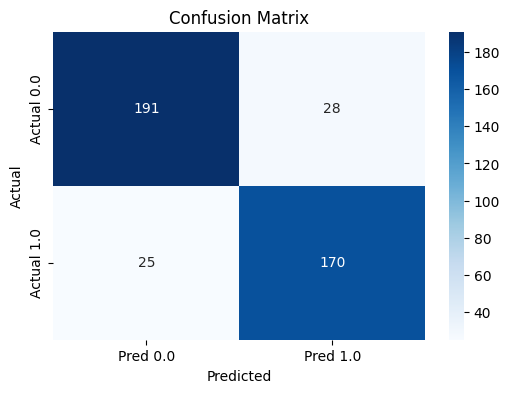

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 8. Predict and evaluate
y_pred = best_svm.predict(X_test)
f1 = f1_score(y_test, y_pred, average="macro")
print(f"\n🎯 Pearson-SVM F1 Score (macro): {f1:.4f}")

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# 9. Confusion Matrix (tabel)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {i}" for i in np.unique(y_test)],
                     columns=[f"Pred {i}" for i in np.unique(y_test)])

print("\n📊 Confusion Matrix (tabel):\n")
print(cm_df)

# 10. Confusion Matrix (visualisasi heatmap)
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [15]:
import joblib
import time

# 6. Save & Load Model

In [16]:
# Save model SVM
joblib.dump(best_svm, "best_svm_model.pkl")
print("✅ Model berhasil disimpan ke best_svm_model.pkl")

✅ Model berhasil disimpan ke best_svm_model.pkl


In [17]:
# Load kembali
loaded_svm = joblib.load("best_svm_model.pkl")
print("✅ Model berhasil dimuat kembali")


✅ Model berhasil dimuat kembali


# 7. Inference Performance Testing

In [18]:
# Ambil subset test (misalnya 11 sample)
sample_texts = X_test[:11]
sample_labels = y_test[:11]

# --- Skenario 1: inference per sample (real-time) ---
latencies = []
for i, x in enumerate(sample_texts):
    start = time.time()
    _ = loaded_svm.predict([x])   # single sample inference
    end = time.time()
    latencies.append((end - start) * 1000)  # ms

print("\n⏱️ Skenario 1: Latency per sample (ms):")
for i, l in enumerate(latencies):
    print(f"Sample {i+1}: {l:.3f} ms")


# --- Skenario 2: inference batch penuh (throughput) ---
start = time.time()
_ = loaded_svm.predict(sample_texts)   # batch predict
end = time.time()
batch_latency = (end - start) * 1000

print(f"\n📦 Skenario 2: Batch inference (11 samples) total latency: {batch_latency:.3f} ms")
print(f"📦 Rata-rata per sample (batch): {batch_latency/len(sample_texts):.3f} ms")


# --- Skenario 3: rata-rata latency beberapa sample (simulasi real-time stream) ---
n_runs = 30
latencies_stream = []
for _ in range(n_runs):
    idx = np.random.randint(0, len(X_test))
    x = X_test[idx]
    start = time.time()
    _ = loaded_svm.predict([x])
    end = time.time()
    latencies_stream.append((end - start) * 1000)

print(f"\n📊 Skenario 3: Rata-rata latency single sample (over {n_runs} runs): {np.mean(latencies_stream):.3f} ms")
print(f"📊 Min: {np.min(latencies_stream):.3f} ms | Max: {np.max(latencies_stream):.3f} ms")


⏱️ Skenario 1: Latency per sample (ms):
Sample 1: 1.172 ms
Sample 2: 1.084 ms
Sample 3: 1.314 ms
Sample 4: 0.907 ms
Sample 5: 1.528 ms
Sample 6: 0.677 ms
Sample 7: 0.575 ms
Sample 8: 0.480 ms
Sample 9: 0.564 ms
Sample 10: 0.613 ms
Sample 11: 0.624 ms

📦 Skenario 2: Batch inference (11 samples) total latency: 3.354 ms
📦 Rata-rata per sample (batch): 0.305 ms

📊 Skenario 3: Rata-rata latency single sample (over 30 runs): 0.559 ms
📊 Min: 0.475 ms | Max: 0.836 ms


In [22]:
import time
import numpy as np

# Ambil beberapa sample (misal 11) untuk tes latency mini-batch
test_batch = X_test[0:11]

# ----- Skenario 1: inference per sample (real-time) -----
latencies = []
for x in test_batch:
    start = time.time()
    _ = loaded_svm.predict([x])   # single sample
    end = time.time()
    latencies.append((end - start) * 1000)  # ms

print("\n⏱️ Latency 11-sample per sample (real-time):")
for i, l in enumerate(latencies):
    print(f"Sample {i+1}: {l:.2f} ms")

# ----- Skenario 2: batch inference (throughput) -----
start = time.time()
_ = loaded_svm.predict(test_batch)  # semua 11 sample sekaligus
end = time.time()
total_time = end - start
print(f"\n📦 Batch inference 11-sample total latency: {total_time:.4f} s")
print(f"📦 Rata-rata per sample: {total_time / len(test_batch) * 1000:.2f} ms")

# ----- Skenario 3: rata-rata latency beberapa single-sample (100 random) -----
n_trials = 100
indices = np.random.choice(len(X_test), n_trials, replace=False)
times = []
for i in indices:
    sample = X_test[i]
    t0 = time.time()
    _ = loaded_svm.predict([sample])
    t1 = time.time()
    times.append((t1 - t0) * 1000)  # ms

print(f"\n📊 Latency rata-rata 100 single-sample: {np.mean(times):.2f} ms ± {np.std(times):.2f} ms")



⏱️ Latency 11-sample per sample (real-time):
Sample 1: 3.03 ms
Sample 2: 1.08 ms
Sample 3: 0.86 ms
Sample 4: 5.93 ms
Sample 5: 0.85 ms
Sample 6: 4.91 ms
Sample 7: 0.89 ms
Sample 8: 2.90 ms
Sample 9: 0.86 ms
Sample 10: 3.27 ms
Sample 11: 0.83 ms

📦 Batch inference 11-sample total latency: 0.0110 s
📦 Rata-rata per sample: 1.00 ms

📊 Latency rata-rata 100 single-sample: 1.82 ms ± 1.11 ms


In [23]:
import time
import numpy as np

# Ambil 11 sample dari test set
test_batch = X_test[0:11]

# ----- Batch inference: prediksi semua 11 sample sekaligus -----
start = time.time()
y_pred_batch = loaded_svm.predict(test_batch)  # single call, 11 sample
end = time.time()

total_latency_ms = (end - start) * 1000
latency_per_sample = total_latency_ms / len(test_batch)

print(f"⏱️ Total latency batch 11 sample: {total_latency_ms:.2f} ms")
print(f"⏱️ Rata-rata latency per sample: {latency_per_sample:.2f} ms")

# Cek hasil prediksi
print("Prediksi batch:", y_pred_batch)


⏱️ Total latency batch 11 sample: 9.17 ms
⏱️ Rata-rata latency per sample: 0.83 ms
Prediksi batch: [1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1.]


In [25]:
import joblib
from sklearn.metrics import classification_report, f1_score

# Load model
loaded_svm = joblib.load("best_svm_model.pkl")

# Pastikan X_test sudah diubah ke embedding FastText
# X_test_embedded = np.array([sentence_to_vector(s, fasttext_model) for s in X_test_raw])

# Prediksi
y_pred = loaded_svm.predict(X_test)

# Metrics
print(classification_report(y_test, y_pred, digits=4))
print("F1 Score (macro):", f1_score(y_test, y_pred, average="macro"))


              precision    recall  f1-score   support

         0.0     0.8843    0.8721    0.8782       219
         1.0     0.8586    0.8718    0.8651       195

    accuracy                         0.8720       414
   macro avg     0.8714    0.8720    0.8717       414
weighted avg     0.8722    0.8720    0.8720       414

F1 Score (macro): 0.8716504343248224


In [26]:
!git clone https://github.com/WilliamAxelC/Indonesian-Cyberbullying-Detection-with-Distilbert.git


Cloning into 'Indonesian-Cyberbullying-Detection-with-Distilbert'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 152 (delta 77), reused 119 (delta 44), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 15.52 MiB | 20.02 MiB/s, done.
Resolving deltas: 100% (77/77), done.
